In [73]:
from PIL import Image
from numpy import asarray

test_img_path = "/data/benign/1.jpg"
img = Image.open(test_img_path)
img = asarray(img)
print(img.shape)

(224, 224, 3)


In [39]:
batch_size = 64
img_height = 224
img_width = 224

In [40]:
import os

data_dir = "/data"
benign_dir = os.path.join(data_dir, "benign")
malignant_dir = os.path.join(data_dir, "malignant")

print("Number of benign images:", len(os.listdir(benign_dir)))
print("Number of malignant images:", len(os.listdir(malignant_dir)))

Number of benign images: 1800
Number of malignant images: 1497


In [42]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [43]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
)

In [44]:
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
)

Found 2638 images belonging to 2 classes.


In [45]:
val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode="categorical",
    subset="validation",
)

Found 659 images belonging to 2 classes.


In [47]:
base_model = NASNetMobile(
    weights="imagenet",
    include_top=False,
    input_shape=(img_height, img_width, 3),
)

19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [48]:
for layer in base_model.layers:
    layer.trainable = False

In [49]:
x = Flatten()(base_model.output)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(2, activation="softmax")(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=output)

In [51]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [52]:
early_stopping = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

In [53]:
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=[early_stopping],
    shuffle=False,
)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.6894 - loss: 1.1890 - val_accuracy: 0.7633 - val_loss: 0.5035
Epoch 2/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.8346 - loss: 0.3889 - val_accuracy: 0.7496 - val_loss: 0.5210
Epoch 3/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.8065 - loss: 0.3988 - val_accuracy: 0.7906 - val_loss: 0.4604
Epoch 4/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8496 - loss: 0.3499 - val_accuracy: 0.7663 - val_loss: 0.5031
Epoch 5/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 81s 998ms/step - accuracy: 0.8379 - loss: 0.3538 - val_accuracy: 0.7678 - val_loss: 0.4883
Epoch 6/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8427 - loss: 0.3455 - val_accuracy: 0.7785 - val_loss: 0.4785
Epoch 7/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8490 - loss: 0.3502 - val_accuracy: 0.7618 - val_loss: 0.4734
Epoch 8/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.8591 - loss: 0.3198 - val_accuracy: 0.7693 - val_loss: 0.4488

In [54]:
model.save("/model.h5")

In [55]:
import matplotlib.pyplot as plt

In [56]:
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
training_accuracy = history.history["accuracy"]
validation_accuracy = history.history["val_accuracy"]

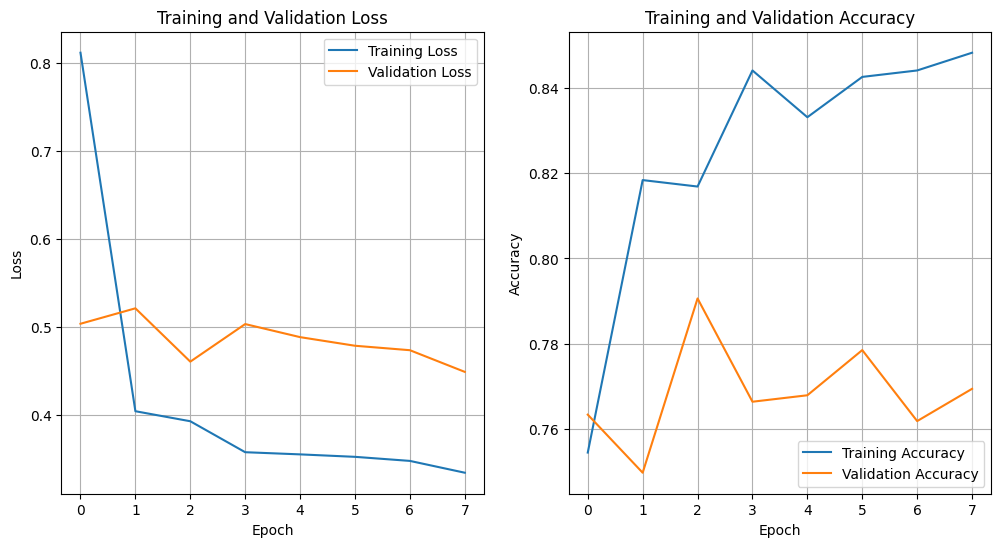

In [57]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(training_loss, label="Training Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label="Training Accuracy")
plt.plot(validation_accuracy, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)